In [ ]:
import os
import torch
import torch.nn as nn  ##Contains modules and classes for building neural networks (CrossEntropyLoss,Conv2d)
import torch.optim as optim  #optimization algorithms to update model weights (adam)
from torch.utils.data import DataLoader  #utility for loading data in batches
from torchvision import datasets, transforms #datasets for computer vision(mnist,ImageFolder)
from efficientnet_pytorch import EfficientNet  #EfficientNet model from PyTorch - fine tune dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm #to visualize training progress - epoch,batches display
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Data preprocessing & augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
DATA_DIR = "/Users/Admin/Desktop/project/face" 
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms) #pytorch automatically assign labels

class_names = full_dataset.classes
print("Classes found:", class_names)

Classes found: ['acne-prone-skin', 'dry-skin', 'healthy', 'oily-skin']


In [ ]:
indices = list(range(len(full_dataset)))
train_idx, valid_idx = train_test_split(indices, test_size=0.2, random_state=42)

from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(full_dataset, batch_size=16, sampler=train_sampler)
valid_loader = DataLoader(full_dataset, batch_size=16, sampler=valid_sampler)


In [ ]:
model = EfficientNet.from_pretrained("efficientnet-b0")

# Replace last layer
num_features = model._fc.in_features
model._fc = nn.Linear(num_features, len(class_names))

model = model.to(device)

print(model._fc)

Loaded pretrained weights for efficientnet-b0
Linear(in_features=1280, out_features=4, bias=True)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # ---------- TRAINING ----------
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")



Epoch 1/10


100%|██████████| 27/27 [02:12<00:00,  4.89s/it]


Train Loss: 1.2495 | Val Loss: 1.2241

Epoch 2/10


100%|██████████| 27/27 [03:41<00:00,  8.19s/it]


Train Loss: 0.9233 | Val Loss: 0.8857

Epoch 3/10


100%|██████████| 27/27 [02:33<00:00,  5.69s/it]


Train Loss: 0.6925 | Val Loss: 0.6764

Epoch 4/10


100%|██████████| 27/27 [01:42<00:00,  3.78s/it]


Train Loss: 0.5457 | Val Loss: 0.5415

Epoch 5/10


100%|██████████| 27/27 [01:57<00:00,  4.33s/it]


Train Loss: 0.4017 | Val Loss: 0.4427

Epoch 6/10


100%|██████████| 27/27 [02:02<00:00,  4.54s/it]


Train Loss: 0.3186 | Val Loss: 0.4593

Epoch 7/10


100%|██████████| 27/27 [01:58<00:00,  4.37s/it]


Train Loss: 0.2644 | Val Loss: 0.4004

Epoch 8/10


100%|██████████| 27/27 [01:58<00:00,  4.38s/it]


Train Loss: 0.2063 | Val Loss: 0.4017

Epoch 9/10


100%|██████████| 27/27 [01:58<00:00,  4.38s/it]


Train Loss: 0.2022 | Val Loss: 0.3443

Epoch 10/10


100%|██████████| 27/27 [02:02<00:00,  4.54s/it]


Train Loss: 0.1993 | Val Loss: 0.3485


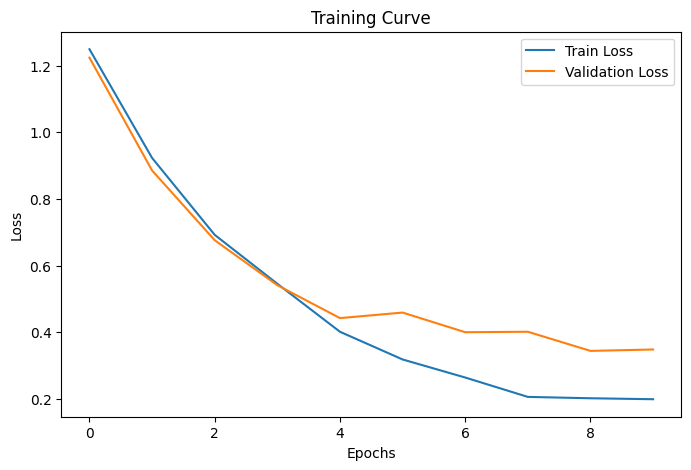

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
SAVE_PATH = "/Users/Admin/Desktop/project/models/efficientnet_skin_classifier.pth"
torch.save(model.state_dict(), SAVE_PATH)

print(f"Model saved to: {SAVE_PATH}")

Model saved to: /Users/Admin/Desktop/project/models/efficientnet_skin_classifier.pth


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


In [ ]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
